In [30]:
from scipy.io import mmread
import pandas as pd
import anndata
from tqdm.notebook import tqdm
import numpy as np
from numba import njit
from multiprocessing import Pool
from functools import partial
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
import gc

## Read Variant Calling Data

In [31]:
NUM_EMBRYOS = 3
VARIANT_MTX_PATHS = ['data/emb1/out_mtrix.mtx', 'data/emb2/out_mtrix.mtx', 'data/emb3/out_mtrix.mtx']
MUTATION_ANNO_PATHS = ['data/emb1/mouse_1.var', 'data/emb2/mouse_2.var', 'data/emb3/mouse_3.var']
CELL_BARCODE_PATHS = ['data/emb1/mouse_1_cell_barcodes.tsv', 'data/emb2/mouse_2_cell_barcodes.tsv', 'data/emb3/mouse_3_cell_barcodes.tsv']

In [32]:
variant_mats = []
mutation_annos = []
cell_barcodes = []

for i in range(NUM_EMBRYOS):
    # Read variant call matrices
    variant_mat = mmread(VARIANT_MTX_PATHS[i])
    variant_mats.append(variant_mat)
    
    # Read the identifiers for the mutations
    with open(MUTATION_ANNO_PATHS[i]) as file:
        lines = file.readlines()
        lines = [line.rstrip() for line in lines]
        
    mutation_annos.append(lines)
    
    # Read the barcodes for the cells
    with open(CELL_BARCODE_PATHS[i]) as file:
        lines = file.readlines()
        lines = [line.rstrip() for line in lines]
        
    cell_barcodes.append(lines)

In [33]:
variant_adatas = []

# Convert each of the variant datasets to anndata
for i in range(NUM_EMBRYOS):
    obs = pd.DataFrame(index=cell_barcodes[i])
    obs['embryo'] = i
    var = pd.DataFrame(index=mutation_annos[i])
    
    adata = anndata.AnnData(obs=obs, var=var, X=variant_mats[i].T)
    variant_adatas.append(adata)

In [34]:
variants_joined = anndata.concat(variant_adatas, join='outer')

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


## Plot Diagnostics for Variant Calling

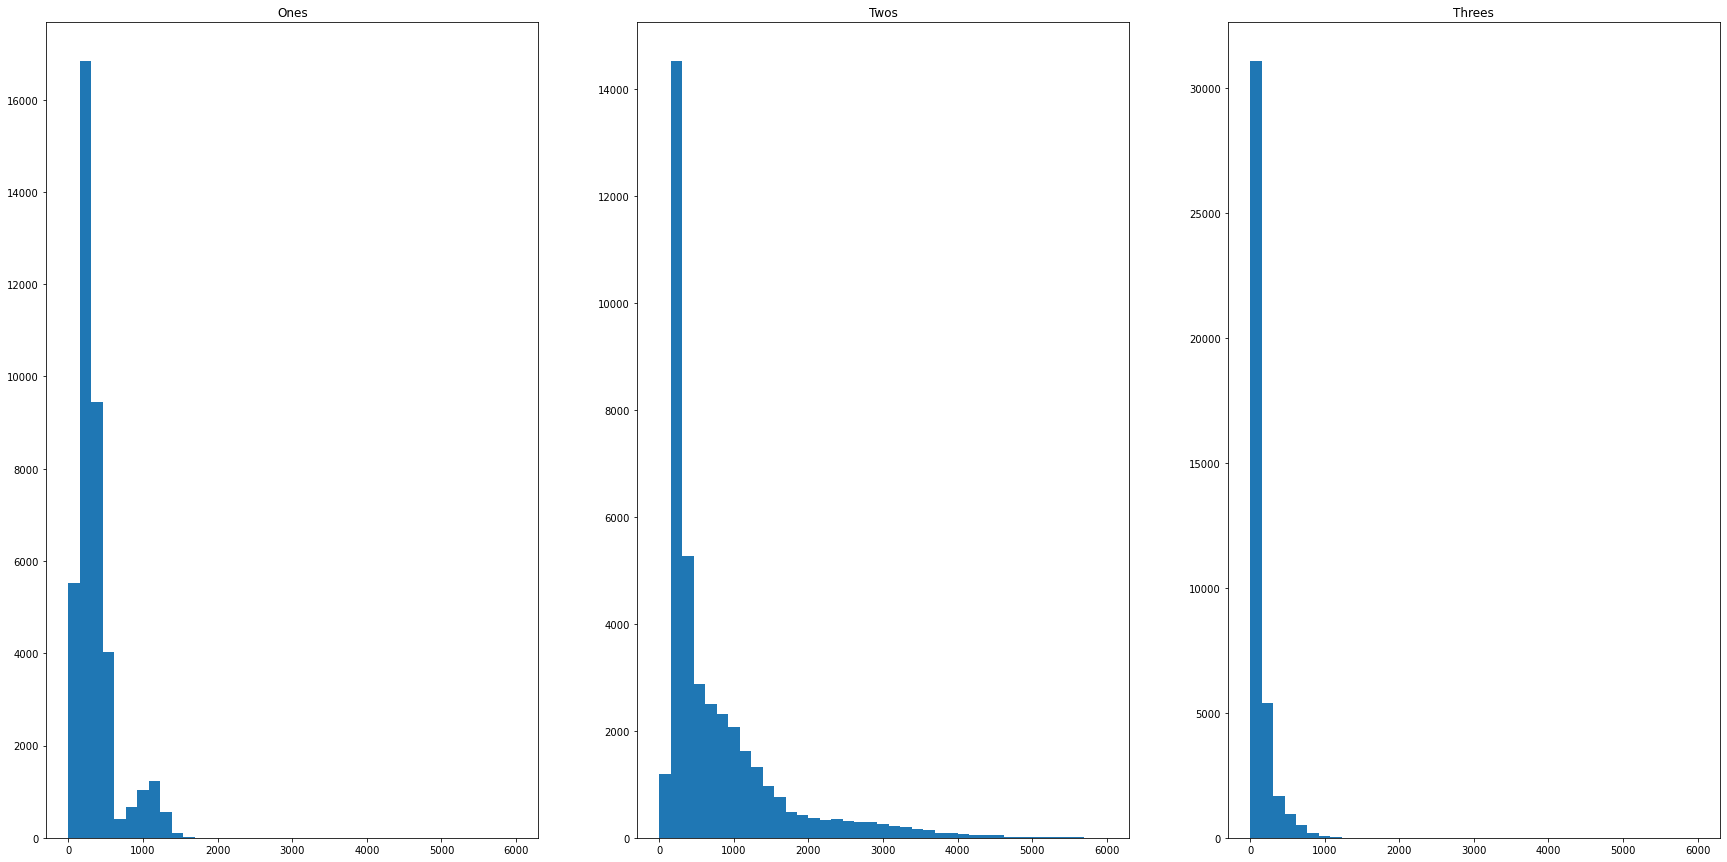

In [33]:
# Plot the counts of each call
threes = np.sum(variants_joined.X.toarray() == 3, axis=1)
twos = np.sum(variants_joined.X.toarray() == 2, axis=1)
ones = np.sum(variants_joined.X.toarray() == 1, axis=1)

plt.figure(figsize=(30, 15))

plt.subplot(131)
plt.title('Ones')
plt.hist(ones, bins=np.linspace(0, 6000, 40))

plt.subplot(132)
plt.title('Twos')
plt.hist(twos, bins=np.linspace(0, 6000, 40))

plt.subplot(133)
plt.title('Threes')
plt.hist(threes, bins=np.linspace(0, 6000, 40))

plt.show()

(array([24332.,  1668.,   640.,   346.,   210.,    91.,    33.,    62.,
           54.,    26.]),
 array([    0. ,  3981.6,  7963.2, 11944.8, 15926.4, 19908. , 23889.6,
        27871.2, 31852.8, 35834.4, 39816. ]),
 [<matplotlib.patches.Polygon at 0x7fb2a5c8bbd0>])

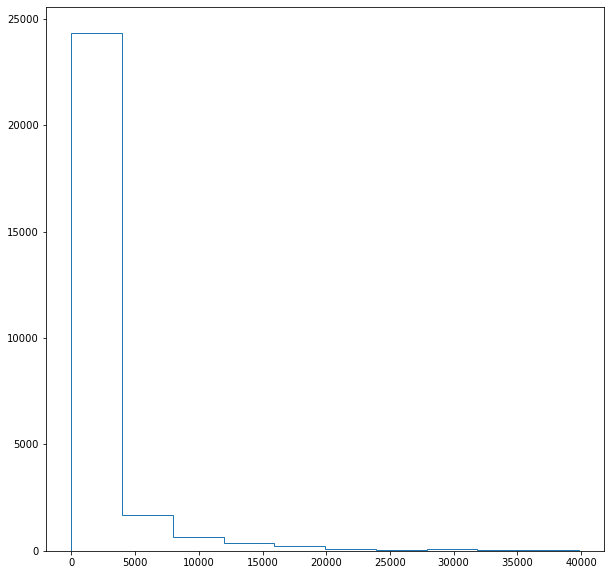

In [18]:
plt.figure(figsize=(10, 10))

variant_sums = np.array((variants_joined.X > 0).sum(axis=0))[0]
plt.hist(variant_sums, histtype='step')

## Filter Variants to only Highly Expressed Ones

In [24]:
cutoff = np.quantile(variant_sums, 0.9)
variants_to_include = variant_sums >= cutoff

In [25]:
variants_joined = variants_joined[:, variants_to_include].copy()

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


## Compute Adjusted Hamming Distances and Cluster

In [27]:
def get_adj_ham_dist_dense(cell1, cell2):
    # Find the shared mutations on which we have a call
    shared_inds = (cell1 != 0) & (cell2 != 0)
    num_shared = np.sum(shared_inds)
    
    # Find the number of variants called differently
    dif_call = cell1[shared_inds] != cell2[shared_inds]
    num_dif = np.sum(dif_call)
    
    return num_dif/num_shared

# Computes the adj hamming distance between the given row_num and 
# all cells above the row_num
def compute_dist_row(row_num):
    global mtx
    
    num_cells = mtx.shape[0]
    dists_row = np.zeros(num_cells)
    
    for i in range(row_num + 1, num_cells):
        dists_row[i] = get_adj_ham_dist_dense(mtx[row_num], mtx[i])
        
    return dists_row

# Computes the distance matrix using adjusted hamming distance
# Assumes rows are cells
def compute_adj_hamming_dists(num_cores=70):
    global mtx
    num_cells = mtx.shape[0]
    
    p = Pool(num_cores)
    dists = list(tqdm(p.imap(compute_dist_row, range(num_cells)), total=num_cells))
    p.close()
    
    dists = np.array(dists)
    
    return dists + dists.T

In [28]:
# We have to make the mtx global because partial doesn't work with
# such big data
mtx = variants_joined.X.toarray()

dists = compute_adj_hamming_dists()
del mtx

  0%|          | 0/39827 [00:00<?, ?it/s]

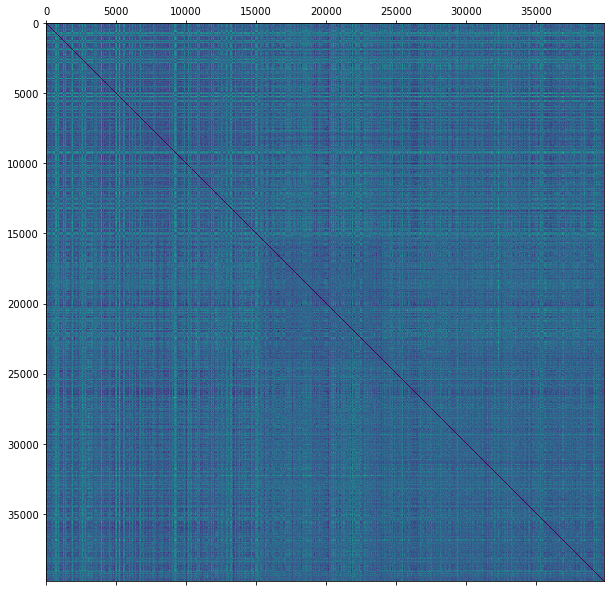

In [29]:
# Plot the distance matrix
plt.figure(figsize=(10, 10))
plt.matshow(dists, fignum=1)
plt.show()

In [9]:
# Get an affinity matrix from out dist matrix
X = np.exp(-dists**2)
#del dists
gc.collect()

1807

In [10]:
spectral_clusters = SpectralClustering(n_clusters=3, affinity='precomputed').fit(X)

In [11]:
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(variants_joined.obs.embryo, spectral_clusters.labels_)

0.12953307348749946